In [1]:
import pandas as pd

df_wine = pd.read_csv('../data/wine/wine.data')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [3]:
import numpy as np

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print(f'Eigenvalues: \n{eigen_vals}')

Eigenvalues: 
[4.79500219 2.50003078 1.44306678 0.99901271 0.87517717 0.67821564
 0.53031813 0.35080209 0.28446498 0.11333093 0.14810971 0.18968162
 0.19934466]


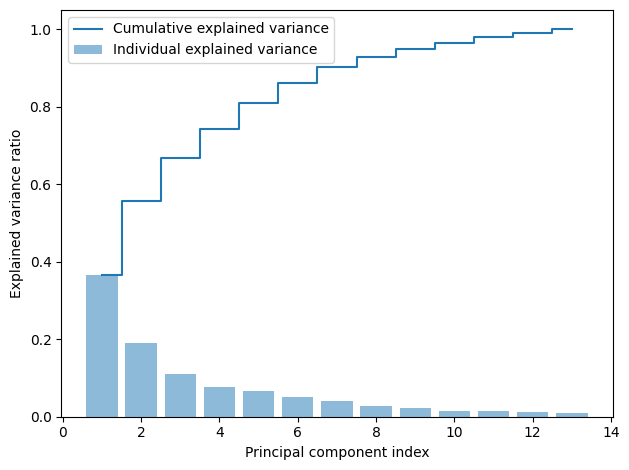

In [4]:
tot = sum(eigen_vals)

var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]

cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt

plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [5]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [6]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W: \n', w)

Matrix W: 
 [[ 0.12221148 -0.49927666]
 [-0.24391049 -0.15419073]
 [ 0.00369454 -0.25170137]
 [-0.249647    0.12269609]
 [ 0.13011026 -0.31420427]
 [ 0.39099441 -0.05595656]
 [ 0.41649235  0.02637354]
 [-0.31569983 -0.07362469]
 [ 0.2982478   0.01094724]
 [-0.07304049 -0.53961007]
 [ 0.31641846  0.21061646]
 [ 0.37253046  0.23649287]
 [ 0.29514562 -0.38598117]]


In [7]:
X_train_std[0].dot(w)

array([-3.60252556, -1.65534122])

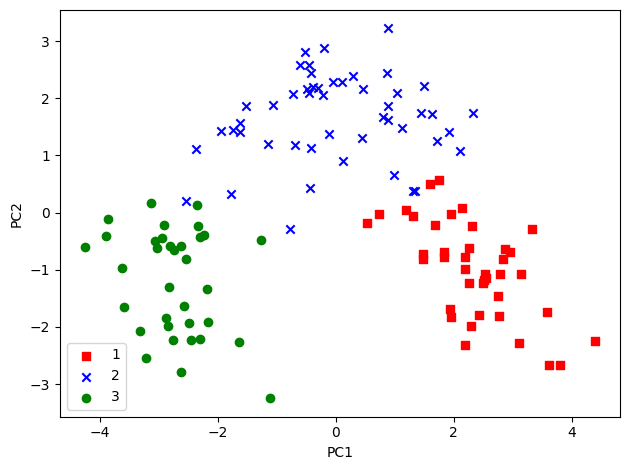

In [8]:
X_train_pca = X_train_std.dot(w)
colors = ['red', 'blue', 'green']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], X_train_pca[y_train == l, 1], c=c, label=l, marker=m)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


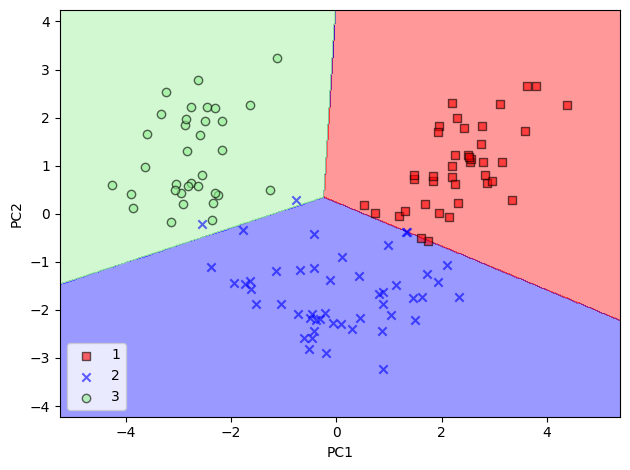

In [9]:
from common.plot_dicision_regions import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr.fit(X_train_pca, y_train)

plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

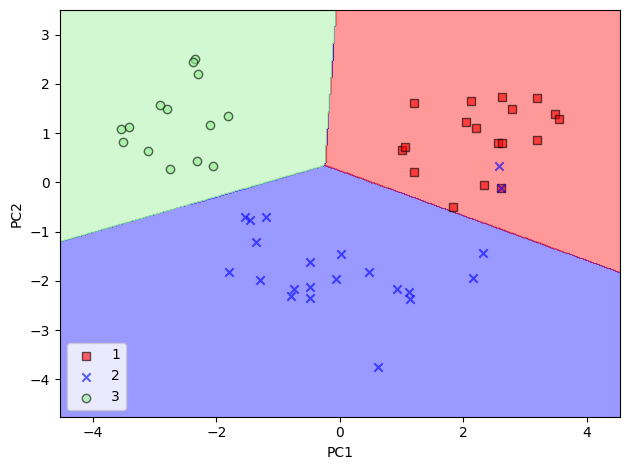

In [10]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [11]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)

pca.explained_variance_ratio_

array([0.36584757, 0.19074656, 0.11010266, 0.07622236, 0.06677399,
       0.05174628, 0.04046205, 0.02676539, 0.02170402, 0.01520954,
       0.01447227, 0.01130043, 0.00864689])

In [15]:
np.set_printoptions(precision=4)
mean_vecs = [np.mean(X_train_std[y_train == label], axis=0) for label in range(1, 4)]
for label in range(1, 4):
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.8807 -0.3428  0.2687 -0.8193  0.4718  0.8881  0.9597 -0.6325  0.4794
  0.2394  0.5838  0.6963  1.2367]

MV 2: [-0.8811 -0.2894 -0.3636  0.3329 -0.398  -0.0317  0.0938 -0.0514  0.137
 -0.8377  0.3394  0.3511 -0.7462]

MV 3: [ 0.2336  0.8204  0.208   0.4841  0.0186 -0.9991 -1.2643  0.8182 -0.7615
  0.9256 -1.1759 -1.3252 -0.3796]


In [18]:
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [19]:
print(f'Class label distribution: {np.bincount(y_train)[1:]}')

Class label distribution: [40 49 34]


In [20]:
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


In [22]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


In [26]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

10.097507739679251
3.746978401075482
8.053540930171302e-16
8.053540930171302e-16
6.474384218868479e-16
5.553508005028526e-16
4.308097394165882e-16
4.308097394165882e-16
4.128691473054921e-16
1.0749154874827579e-16
1.0749154874827579e-16
7.23751824231657e-17
0.0


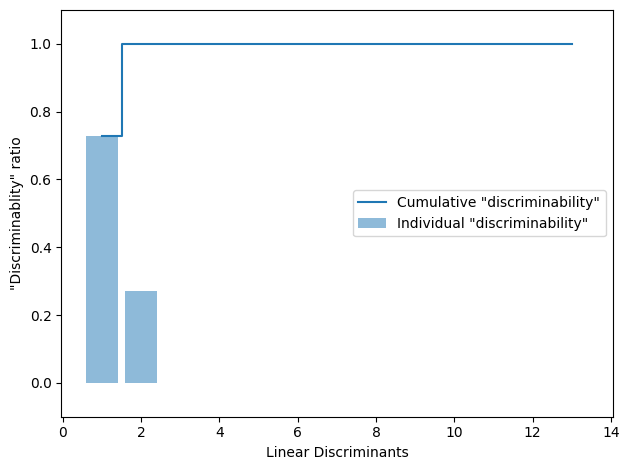

In [27]:
tot = sum(eigen_vals.real)

discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='Individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid', label='Cumulative "discriminability"')
plt.ylabel('"Discriminablity" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [28]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1051 -0.3514]
 [ 0.0613 -0.1931]
 [ 0.0236 -0.273 ]
 [ 0.1363  0.285 ]
 [-0.01   -0.0378]
 [ 0.1833  0.0836]
 [-0.7585  0.2052]
 [-0.0551  0.0526]
 [ 0.0036  0.1543]
 [ 0.2842 -0.25  ]
 [-0.099   0.2321]
 [-0.3511 -0.0195]
 [-0.3743 -0.6997]]


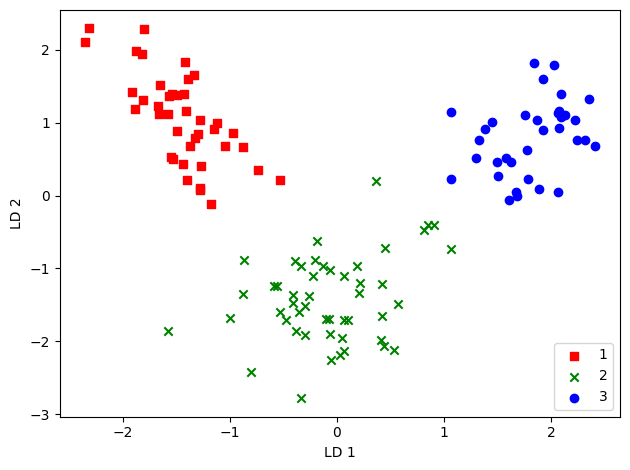

In [32]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'g', 'b']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0], X_train_lda[y_train == l, 1] * (-1), c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

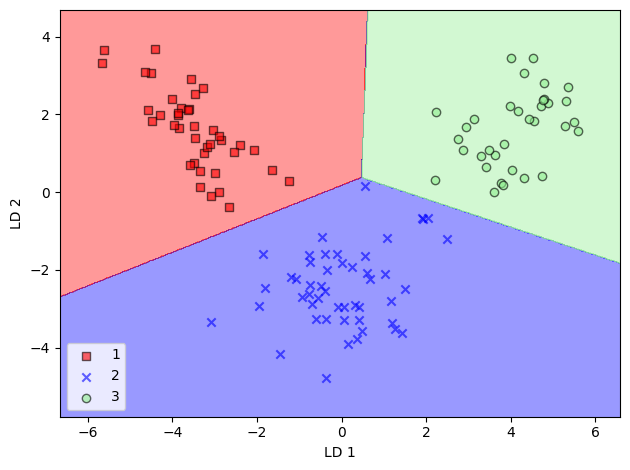

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

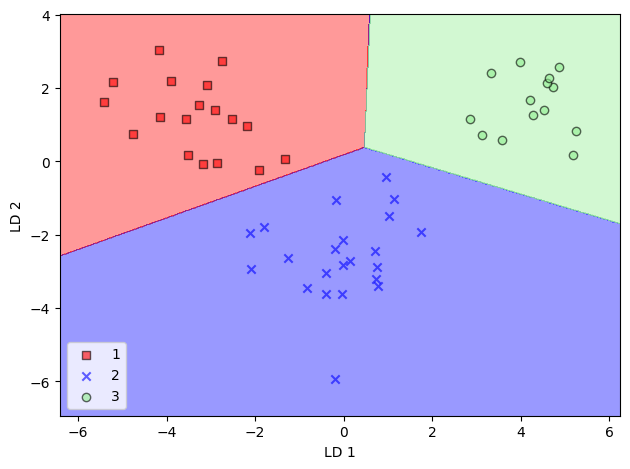

In [34]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [39]:
from scipy.spatial.distance import pdist, squareform
from numpy import exp
from scipy.linalg import eigh


def rbf_kernel_pca(X, gamma, n_components):
    sq_dists = pdist(X, 'sqeuclidean')

    mat_sq_dists = squareform(sq_dists)

    K = exp(-gamma * mat_sq_dists)

    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    X_pc = np.column_stack([eigvecs[:, i] for i in range(n_components)])

    return X_pc

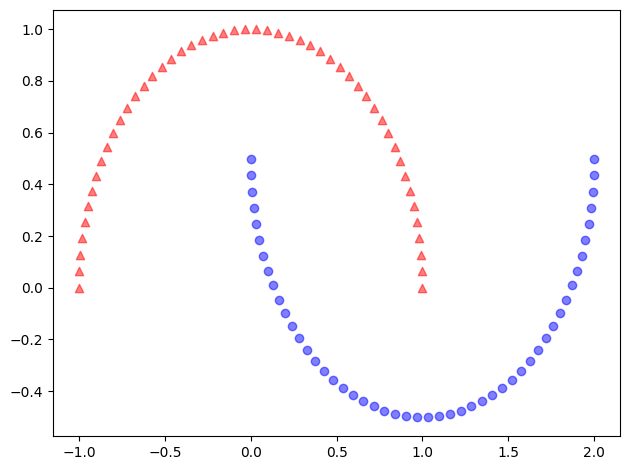

In [40]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', marker='o', alpha=0.5)
plt.tight_layout()
plt.show()

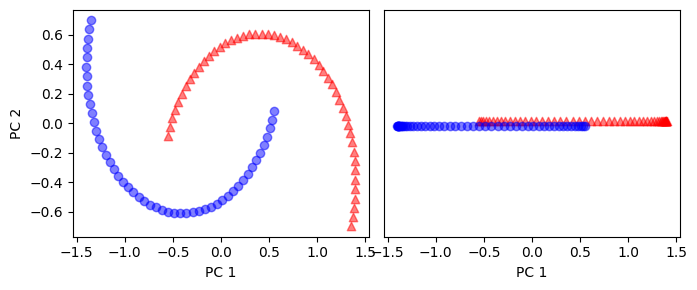

In [41]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)

X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1], c='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1], c='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02, c='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02, c='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC 1')
ax[0].set_ylabel('PC 2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC 1')
plt.tight_layout()
plt.show()

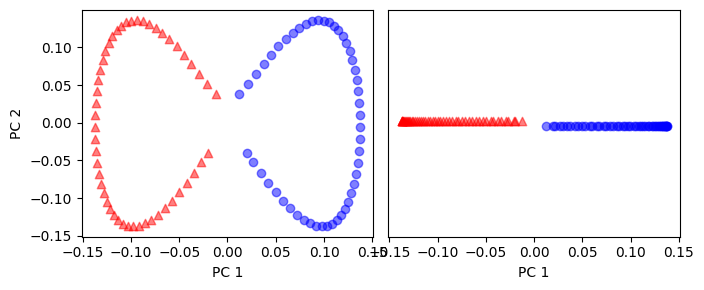

In [42]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1], c='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1], c='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((50, 1)) + 0.02, c='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((50, 1)) - 0.02, c='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC 1')
ax[0].set_ylabel('PC 2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC 1')
plt.tight_layout()
plt.show()

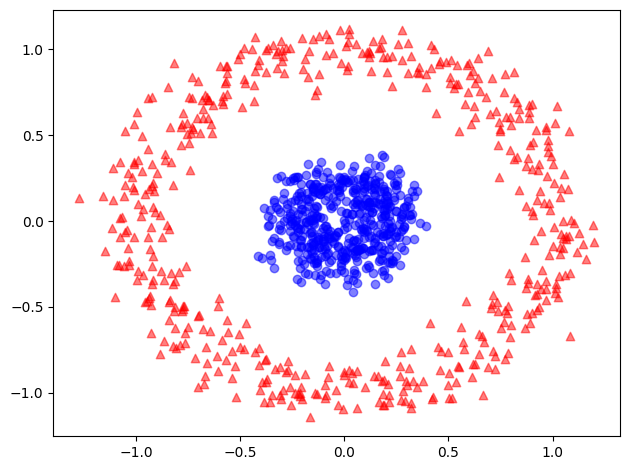

In [43]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', marker='o', alpha=0.5)
plt.tight_layout()
plt.show()

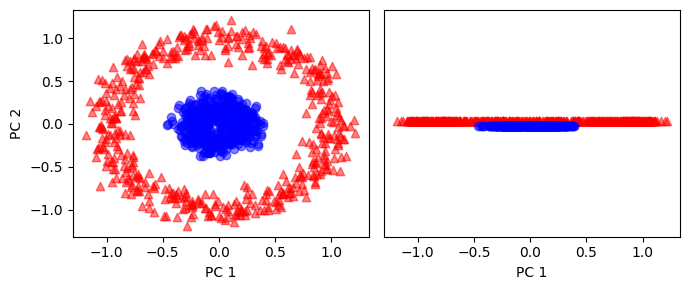

In [46]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC 1')
ax[0].set_ylabel('PC 2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC 1')

plt.tight_layout()
plt.show()

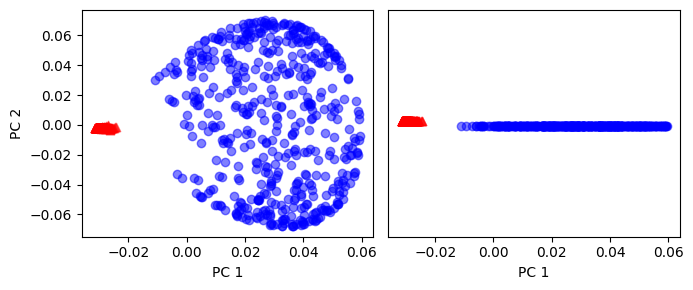

In [49]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
flg, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1], c='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1], c='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC 1')
ax[0].set_ylabel('PC 2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC 1')

plt.tight_layout()
plt.show()

In [50]:
def rbf_kernel_pca(X, gamma, n_components):
    sq_dists = pdist(X, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dists)
    
    K = exp(-gamma * mat_sq_dists)
    
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[:: -1], eigvecs[:, :: -1]
    
    alphas = np.column_stack([eigvecs[:, i] for i in range(n_components)])
    lambdas = [eigvals[i] for i in range(n_components)]
    
    return alphas, lambdas

In [54]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

x_new = X[25]
x_new

array([1.8713, 0.0093])

In [55]:
x_proj = alphas[25]
x_proj

array([0.0788])

In [57]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row) ** 2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

x_reporj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reporj

array([0.0788])

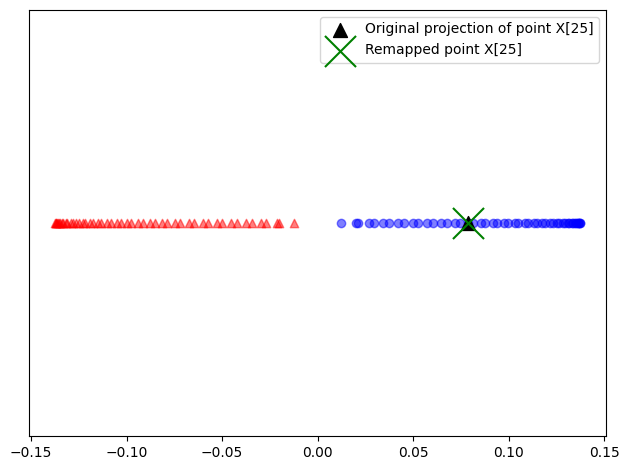

In [58]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)), color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)), color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black', label='Original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reporj, 0, color='green', label='Remapped point X[25]', marker='x', s=500)
plt.yticks([], [])
plt.legend(scatterpoints=1)
plt.tight_layout()
plt.show()

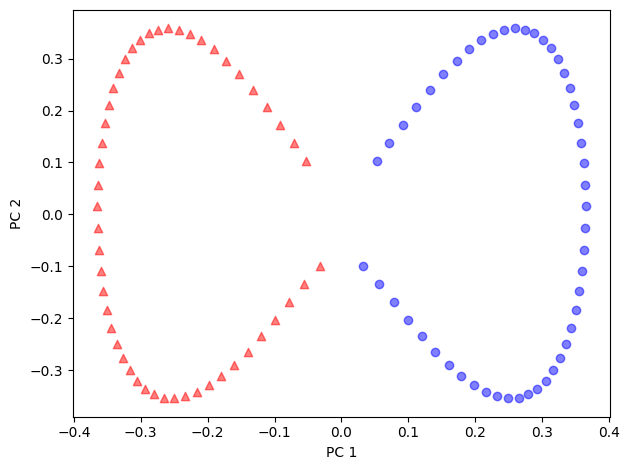

In [59]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1], color='blue', marker='o', alpha=0.5)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.tight_layout()
plt.show()